# Kaggle: MNIST Digit Recognizer

## A ResNet inspired approach

This notebook creates a submission to the [Kaggle](https://www.kaggle.com/) [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) competition. Kaggle provides a training set with 42,000 MNIST digit images and evaluates a submission on the 28,000 images in the test set. For my submission I train a residual neural network (ResNet) similar to the one provided in the book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by Aurélien Géron (p. 478). Using data augmentation and an Adam optimizer, this model achieves a 99.47% accuracy on the unseen test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("tensorflow: " + tf.__version__)

pandas: 1.1.4
numpy: 1.18.5
tensorflow: 2.3.1


In [3]:
# uncomment to download the train set
# !kaggle competitions download -c digit-recognizer
# then unzip the file

### Data Cleaning

The images are stored in csv files and have to be reshaped to represent a 28x28 pixel grayscale image. The labels stand for the ten digits 0-9.

In [4]:
def load_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    return train, test

In [5]:
def split_Xy(df):
    y = df["label"]
    X = df.drop(["label"], axis=1)
    return X, y

In [6]:
def reshape_X(df):
    return df.values.reshape(-1, 28, 28, 1)

In [7]:
train, _ = load_data()
X_train, y_train = split_Xy(train)
X_train = reshape_X(X_train)

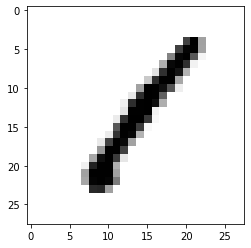

In [8]:
# some examples
g = plt.imshow(X_train[0][:, :, 0], cmap=plt.cm.binary)

### Creating the model

The ResNet model is created and a summary is given:

In [9]:
def define_model():
    
    class ResidualUnit(tf.keras.layers.Layer):
        
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = tf.keras.activations.get(activation)
            self.main_layers = [
                tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                       padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                tf.keras.layers.Conv2D(filters, 3, strides=1,
                                       padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]
            
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                       padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]
                
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            Z_skip = inputs
            for layer in self.skip_layers:
                Z_skip = layer(Z_skip)
            
            return self.activation(Z + Z_skip)
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 5, strides=2,
                                     padding="same", use_bias=False,
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2,
    #                                    padding="same"))
    
    prev_filters = 32
    for filters in [32] * 2 + [64] * 2 + [128] * 2 + [256] * 1:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    
    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    return model

In [10]:
tf.keras.backend.clear_session()

define_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        800       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 14, 14, 32)        18688     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 14, 14, 32)        18688     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)          58112     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 7, 7, 64)          7

The size of the training set is artificially increased by using data augmentation. This transforms an image slightly (by zooming, shifting, rotating, ...) every time the image is used in the training process.

In [11]:
test_size = 0.1

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=10,  
                                                                shear_range=10,
                                                                zoom_range=0.1,
                                                                width_shift_range=0.1, 
                                                                height_shift_range=0.1,
                                                                fill_mode="constant",
                                                                cval=0.0,
                                                                validation_split=test_size)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,                                                            
                                                              validation_split=test_size)

The model is trained on 90% of the training set using an Adam optimizer with a hypertuned learning rate.

In [19]:
num_epochs = 128
batch_size = 512
random_state = 3
batches_per_epoch = len(X_train) * (1 - test_size) // batch_size
lr = 1e-2
lr_decay = (1. / 0.75 - 1) / batches_per_epoch


tf.keras.backend.clear_session()

model = define_model()

optimizer = tf.keras.optimizers.Adam(lr=lr, decay=lr_decay)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size, subset="training", seed=random_state),
                    validation_data=val_datagen.flow(X_train, y_train, subset="validation", seed=random_state),
                    epochs=num_epochs, verbose=2)

Epoch 1/128
74/74 - 7s - loss: 0.4636 - accuracy: 0.8539 - val_loss: 5.2916 - val_accuracy: 0.2160
Epoch 2/128
74/74 - 7s - loss: 0.0846 - accuracy: 0.9743 - val_loss: 0.5228 - val_accuracy: 0.8486
Epoch 3/128
74/74 - 7s - loss: 0.0579 - accuracy: 0.9817 - val_loss: 0.8684 - val_accuracy: 0.7788
Epoch 4/128
74/74 - 7s - loss: 0.0481 - accuracy: 0.9851 - val_loss: 0.0907 - val_accuracy: 0.9745
Epoch 5/128
74/74 - 7s - loss: 0.0436 - accuracy: 0.9864 - val_loss: 0.0454 - val_accuracy: 0.9864
Epoch 6/128
74/74 - 7s - loss: 0.0323 - accuracy: 0.9897 - val_loss: 0.0591 - val_accuracy: 0.9831
Epoch 7/128
74/74 - 7s - loss: 0.0323 - accuracy: 0.9899 - val_loss: 0.0926 - val_accuracy: 0.9714
Epoch 8/128
74/74 - 7s - loss: 0.0269 - accuracy: 0.9911 - val_loss: 0.0318 - val_accuracy: 0.9893
Epoch 9/128
74/74 - 7s - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0380 - val_accuracy: 0.9876
Epoch 10/128
74/74 - 7s - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0552 - val_accuracy: 0.9838
Epoch 11/

74/74 - 7s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0267 - val_accuracy: 0.9924
Epoch 84/128
74/74 - 7s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0238 - val_accuracy: 0.9919
Epoch 85/128
74/74 - 7s - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 86/128
74/74 - 7s - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0172 - val_accuracy: 0.9948
Epoch 87/128
74/74 - 7s - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0205 - val_accuracy: 0.9940
Epoch 88/128
74/74 - 7s - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0213 - val_accuracy: 0.9955
Epoch 89/128
74/74 - 7s - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0203 - val_accuracy: 0.9957
Epoch 90/128
74/74 - 7s - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0210 - val_accuracy: 0.9940
Epoch 91/128
74/74 - 7s - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0205 - val_accuracy: 0.9948
Epoch 92/128
74/74 - 7s - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0198 - val_accuracy: 0.9943
Epoch 93/128


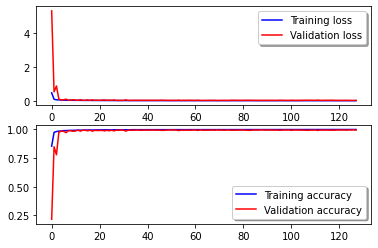

In [20]:
# plot training and validation loss and accuracy
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

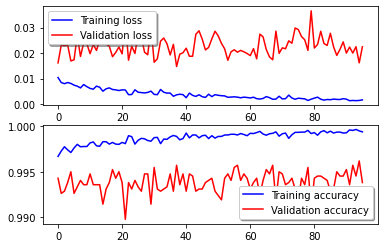

In [21]:
# exclude the first 32 instances to improve the plots
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'][32:], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'][32:], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'][32:], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'][32:], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Making predictions

The model is then trained on the whole training set to further improve it. Then predictions are made on the test set and submitted to Kaggle

In [22]:
model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
          epochs=32, verbose=2)

Epoch 1/32
83/83 - 8s - loss: 0.0040 - accuracy: 0.9989
Epoch 2/32
83/83 - 7s - loss: 0.0035 - accuracy: 0.9990
Epoch 3/32
83/83 - 7s - loss: 0.0028 - accuracy: 0.9989
Epoch 4/32
83/83 - 7s - loss: 0.0030 - accuracy: 0.9989
Epoch 5/32
83/83 - 7s - loss: 0.0039 - accuracy: 0.9990
Epoch 6/32
83/83 - 7s - loss: 0.0032 - accuracy: 0.9991
Epoch 7/32
83/83 - 7s - loss: 0.0025 - accuracy: 0.9991
Epoch 8/32
83/83 - 7s - loss: 0.0031 - accuracy: 0.9989
Epoch 9/32
83/83 - 7s - loss: 0.0021 - accuracy: 0.9993
Epoch 10/32
83/83 - 7s - loss: 0.0032 - accuracy: 0.9989
Epoch 11/32
83/83 - 7s - loss: 0.0044 - accuracy: 0.9987
Epoch 12/32
83/83 - 7s - loss: 0.0112 - accuracy: 0.9971
Epoch 13/32
83/83 - 7s - loss: 0.0036 - accuracy: 0.9990
Epoch 14/32
83/83 - 7s - loss: 0.0065 - accuracy: 0.9980
Epoch 15/32
83/83 - 8s - loss: 0.0071 - accuracy: 0.9979
Epoch 16/32
83/83 - 7s - loss: 0.0035 - accuracy: 0.9989
Epoch 17/32
83/83 - 7s - loss: 0.0020 - accuracy: 0.9995
Epoch 18/32
83/83 - 7s - loss: 0.0016 - 

In [23]:
_, test = load_data()
X_test = reshape_X(test)

results = model.predict(val_datagen.flow(X_test, shuffle=False))

results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), results], axis = 1)

submission.to_csv("submission.csv",index=False)

In [25]:
# uncomment to commit
#!kaggle competitions submit -c digit-recognizer -f submission.csv -m "add submission details"

Successfully submitted to Digit Recognizer



  0%|          | 0.00/235k [00:00<?, ?B/s]
  3%|3         | 8.00k/235k [00:00<00:03, 70.5kB/s]
100%|##########| 235k/235k [00:02<00:00, 80.7kB/s] 


This yields a 99.47% accuracy on the test set.